In [1089]:
# Ensure that the root directory is in Python's path. This is to make importing
# custom library easier.
from pathlib import Path
import sys
root = Path('.').absolute().parent.parent
if str(root) not in sys.path:
    sys.path.append(str(root))

# built-in packages
from collections import defaultdict
import json
from typing import List, Dict, Tuple, Callable
import math

# external packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy
import dill

# matplotlib param
# https://stackoverflow.com/a/55188780/9723036
# SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
TEXT_BOTTOM = 0.9

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

np.set_printoptions(formatter={'float': lambda x: "{0:0.10f}".format(x)})

# Initialize Parameters

In [1136]:
ACTIONS = [[-1, 0], [0, 1], [1, 0], [0, -1]]  # N, W, S, E
M = 10  # number of rows
N = 10  # number of columns
NUM_BLK = 15  # number of blocks
GAMMA = 0.9  # discount rate
ALPHA = 0.1  # learning rate
OPTIMAL_STEPS = 18  # empirically acquired
EPSILON = 0.2  # for epsilon-greedy method
LAMBDA = 0.8  # for eligibility tracing

# Shared Functions

In [1092]:
def initialize_grid(num_rows: int, num_cols: int, num_blocks: int, random_state: int = 42):
    """Initialize a grid world, with obstacles.

    :param num_rows: Number of rows in the grid world.
    :param num_cols: Number of columns in the grid world.
    :param num_blocks: Number of RANDOM blocks that agent cannot cross. The final grid world
        could include more blocks as additional  a manually 
    :param random_state: For reproducing random values.
    :return: Grid for state values, action values, and the coordinates for blocks.
    """
    # Create a grid
    grid = np.array([[0] * num_cols for _ in range(num_rows)])
    V = np.array([[0.0] * num_cols for _ in range(num_rows)])  # initial state values
    Q = np.array([[[0.0] * len(ACTIONS) for _ in range(num_cols)] for _ in range(num_rows)])  # initial action values
    # randomly generate blocks
    rng = np.random.default_rng(random_state)
    block_i = rng.integers(low=0, high=num_rows, size=num_blocks)
    block_j = rng.integers(low=0, high=num_cols, size=num_blocks)
    
    ###################################################
    # hardcodede additional blocks, such that we can  #
    # limit the possible number of ways to reach the  #
    # terminal state                                  #
    ###################################################
    block_i = np.append(block_i, [8, 8, 8])
    block_j = np.append(block_j, [4, 5, 6])
    
    # Update grid and state values by identifying the blocks
    grid[block_i, block_j] = 1
    V[block_i, block_j] = -1000.0

    # Update state action values to set the illegal actions to a big negative value
    for i in range(num_rows):
        for j in range(num_cols):
            if i == num_rows - 1 and j == num_cols - 1:  # not touching the terminal state
                continue
            if grid[i, j] == 1:  # the blocks
                Q[i, j] = np.full(4, -1000.0)
                continue
            for k, (di, dj) in enumerate(ACTIONS):
                ni, nj = i + di, j + dj
                if not (0 <= ni < m and 0 <= nj < n and grid[ni, nj] == 0):
                    Q[i, j, k] = -1000.0

    # initialize random policy
    pi = np.array([[-1] * M for _ in range(N)])
    for i in range(M):
        for j in range(N):
            if (i == M - 1 and j == N - 1) or grid[i][j]:
                continue  # skip terminal state and blocks
            pot_actions = []
            for idx, (di, dj) in enumerate(ACTIONS):
                ni, nj = i + di, j + dj
                if 0 <= ni < M and 0 <= nj < N and grid[ni, nj] == 0:
                    pot_actions.append(idx)
            if pot_actions:
                pi[i, j] = rng.choice(pot_actions)
    
    return np.copy(V), np.copy(Q), grid, np.copy(pi)


def get_next_state_vals(i: int, j: int, V, grid, fv: Callable = lambda v: v):
    """Given the current state i, j, return its next state values.

    To be more specific, we return the state values of all possible states
    that a next action can lead to, based on the given V. The order of
    the next state values is the same as ACTIONS.

    :param i: Row index.
    :parma j: Column index.
    :param V: State values.
    :param grid: Grid.
    :param fv: A lambda function that takes state value as argument and returns a
        new value used for next state values. Default to a lambda that returns the
        input state value (i.e., output and input is the same) 
    :return: A numpy array of shape (4, ) that contains the next state
        values. If an action leads to a invalid state, such as out of bound
        or hitting a block, its value is set to negative infinite.
    """
    next_state_values = []  # store all Next State ValueS
    for di, dj in ACTIONS:
        ni, nj = i + di, j + dj
        if 0 <= ni < M and 0 <= nj < N and grid[ni, nj] == 0:
            next_state_values.append(fv(V[ni, nj]))
        else:
            next_state_values.append(-math.inf)
    return np.array(next_state_values)


def find_best_actions(next_state_values) -> List[int]:
    """Find the best action for an agent based on the given next state values

    Note that there could be multiple best actions if multiple next state values
    are maximum.

    :param next_state_values: A list of state values corresponding to the next
        state achieved from taking the actions in ACTIONS. The order of this
        list of state values correspond to the order in ACTIONS.
    :return: A list of indices correspinding to the best action to take.
    """
    max_V = max(next_state_values)
    sorted_indices = np.argsort(np.array(next_state_values))
    # find all the potential action indices. This is to handle the situation
    # where multiple actions lead to the same next state value. When that
    # happens, we randomly pick an action to go.
    return [idx for idx in sorted_indices if np.isclose(next_state_values[idx], max_V)]


def steps_to_go(V, grid, random_state: int = 42) -> int:
    """Compute on average the number of steps needed to reach terminal state from start.

    Tie breaks on state value is a random choice. We also have a high bound on the number
    of steps to take. If the path search results in steps larger than the high bound, it
    is very likely that the state values are incomplete and contain loop. In that case,
    we exist the path search and directly assign the high bound as the number of steps.

    :param V: State values of the grid world.
    :param grid: The grid world.
    :param random_state: For reproducing random values.
    :return: Average number of steps to reach terminal state.
    """
    max_step_allowed = 1000  # if steps count go beyond this value, we terminate the search
    m, n = V.shape
    rng = np.random.default_rng(random_state)
    total_steps = 0
    total_iteration = 50  # walk the agent 50 times, take the average steps at the end
    for _ in range(total_iteration):
        i, j = 0, 0
        cur_steps = 0
        deterministic = True  # flag to indicate whether a deterministic path can be found
        while (i != m - 1 or j != n - 1) and cur_steps < max_step_allowed:
            nsvs = get_next_state_vals(i, j, V, grid)
            best_acts = find_best_actions(nsvs)
            if len(best_acts) > 1:
                deterministic = False
            next_idx = rng.choice(best_acts)
            i, j = i + ACTIONS[next_idx][0], j + ACTIONS[next_idx][1]
            cur_steps += 1
        if deterministic:  # already deterministic, we can end already
            return cur_steps
        if cur_steps == max_step_allowed:  # If V hasn't converged, return high bound directy
            return cur_steps
        total_steps += cur_steps
    return total_steps / total_iteration


def update_policy(V, pi, grid):
    """Update the current policy pi given new state values V

    :param V: Current state values.
    :param pi: previous policy.
    :param grid: The grid world.
    """
    m, n = pi.shape
    for i in range(m):
        for j in range(n):
            if pi[i, j] >= 0:
                nsvs = get_next_state_vals(i, j, V, grid)
                if nsvs[pi[i, j]] < max(nsvs):  # current policy is not optimal
                    pi[i, j] = np.argmax(nsvs)


def get_epsilon_greedy_action(Q, i: int, j: int, grid) -> int:
    """Use epsilon-greedy method to generate an action based on state, action pair.

    With epsilon probablity, we exploit. With 1 - epsilon probability, we explore.

    :param Q: state, active values.
    :param i: Row index of the state.
    :param j: Column index of the state.
    :param grid: The grid world.
    """
    while True:  # choose a legal action based on epsilon-greedy
        method = rng.choice(['explore', 'exploit'], p=[EPSILON, 1 - EPSILON])
        if method == 'explore':
            act = rng.choice(len(ACTIONS))
        else:
            best_acts = find_best_actions(Q[i, j])
            act = rng.choice(best_acts)
        di, dj = ACTIONS[act]
        ni, nj = i + di, j + dj
        if 0 <= ni < m and 0 <= nj < n and grid[ni, nj] == 0:
            return act  # valid action

# Plot Related

In [1123]:
def plot_step_to_go(ax, steps, optimal_steps: int, title: str):
    """Plot step-to-go vs. episode

    :param ax: An axis object of matplotlib.
    :param steps: Number of expected steps to reach the target for each episode.
    :param optimal_steps: The optimal number of steps to reach the target.
    :param title: Title for the step-to-go plot
    """
    ax.plot(np.arange(1, len(steps) + 1), steps, marker='o', color='C0', label='Steps to Go')
    ax.axhline(optimal_steps, color='C2', label='Optimal Steps')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Steps')
    ax.set_title(title)
    ax.legend()


def plot_rms_error(ax, rms, title: str):
    """Plot RMS error vs. episode

    :param ax: An axis object of matplotlib.
    :param rms: The rms error for each episode.
    :param title: Title for the step-to-go plot
    """
    ax.plot(np.arange(1, len(rms) + 1), rms, marker='s', color='C1', label='RMS')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('RMS')
    ax.set_title(title)
    ax.legend()


def plot_state_value_heatmap(ax, V, fig, title: str, color_vmin: int = -15, color_vmax: int = 0):
    """Plot state value as a heatmap.

    :param ax: An axis object of matplotlib.
    :param V: The final estimated state values.
    :param fig: The fig parameter, acquired when calling plt.subplots().
    :param title: Title for the step-to-go plot.
    :param color_vmin: Min value for the color map indicator, default to -15.
    :param color_vmax: Max value for the color map indicator, default to 0.
    """
    hm = ax.imshow(
        V,
        cmap='hot',
        interpolation='nearest',
        vmin=-15,  # colorbar min
        vmax=0,  # colorbar max
    )
    cbar = fig.colorbar(hm)
    cbar.set_label('State Value')
    # add V value to each heatmap cell
    m, n = V.shape
    for i in range(m):
        for j in range(n):
            val = '-inf' if V[i, j] <= -1000.0 else f'{V[i, j]:.2f}'
            ax.annotate(val, xy=(j - 0.5, i + 0.1), fontsize=10)
    ax.set_title(title)


def plot_path(ax, pi, grid, title: str):
    """Plot a route from start to end on the grid world.

    Yellow is start; green is end; brown is obstacle.

    :param ax: An axis object of matplotlib.
    :parma pi: The final policy.
    :param grid: The grid world.
    :param title: Title for the step-to-go plot
    """
    m, n = pi.shape
    ax.grid(True)
    ax.set_xticks(np.arange(n))
    ax.set_xlim(left=0, right=n)
    ax.set_yticks(np.arange(m))
    ax.set_ylim(top=m - 1, bottom=-1)
    ax.invert_yaxis()  # invert y axis such that 0 is at the top
    i = j = 0
    while i != m - 1 or j != n - 1:
        di, dj = ACTIONS[pi[i, j]]
        ni, nj = i + di, j + dj
        ax.plot([j + 0.5, nj + 0.5], [i - 0.5, ni - 0.5], color='red', lw=2)
        i, j = ni, nj
    # label start, end and blocks
    ax.add_patch(Rectangle((0, -1), 1, 1, fill=True, color='yellow'))
    ax.add_patch(Rectangle((n - 1, m - 2), 1, 1, fill=True, color='green'))
    for i, j in zip(*np.where(grid == 1)):
        ax.add_patch(Rectangle((j, i - 1), 1, 1, fill=True, color='brown'))
    ax.set_title(title)


def plot(steps, rms, V, pi, optimal_steps: int, title: str):
    """Plot the training data and results.
    
    This function plots four graphs.
    1. Step-to-go vs. episode
    2. RMS error vs. episode
    3. State value as a heatmap
    4. One route found by the reinforcement learning to reach destination.

    :param steps: Number of expected steps to reach the target for each episode.
    :param rms: The rms error for each episode.
    :param V: The final estimated state values.
    :parma pi: The final policy
    :param optimal_steps: The optimal number of steps to reach the target.
    :param title: The title for the plot, also serving as the filename of the saved
        plot file.
    """
    plt.rc('grid', linestyle="-", color='black')
    fig, axes = plt.subplots(2, 2, figsize=(13, 13))
    axes = axes.flatten()
    
    plot_step_to_go(axes[0], steps, optimal_steps, '(A)')
    plot_rms_error(axes[1], rms, '(B)')
    plot_path(axes[2], pi, grid, '(C)')
    plot_state_value_heatmap(axes[3], V, fig, '(D)')
    
    fig.suptitle(title)
    plt.tight_layout()
    filename = ''.join(title.split())
    plt.savefig(f'{filename}.pdf')

# Dynamic Programming

## Iterative Policy Evaluation

* Random action

In [1094]:
dp_it_pol_eval_V, _, grid, dp_it_pol_eval_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
V_pre = np.copy(dp_it_pol_eval_V)
dp_it_pol_eval_steps = []
dp_it_pol_eval_rms = []
for _ in range(30):
    # Iterate through ALL states
    for i in range(M):
        for j in range(N):
            if (i == M - 1 and j == N - 1) or grid[i][j]:
                continue  # skip terminal state and blocks
            num_action_taken = 0
            total = 0
            for di, dj in ACTIONS:
                ni, nj = i + di, j + dj
                if 0 <= ni < M and 0 <= nj < N and grid[ni, nj] == 0:
                    num_action_taken += 1
                    total += (-1 + GAMMA * V_pre[ni, nj])
            dp_it_pol_eval_V[i, j] = total / num_action_taken
    # Compute error metrics
    dp_it_pol_eval_steps.append(steps_to_go(dp_it_pol_eval_V, grid))
    dp_it_pol_eval_rms.append(np.linalg.norm(dp_it_pol_eval_V - V_pre) / (M * N))
    V_pre = np.copy(dp_it_pol_eval_V)

update_policy(dp_it_pol_eval_V, dp_it_pol_eval_pi, grid)
dp_it_pol_eval_steps = np.array(dp_it_pol_eval_steps)
dp_it_pol_eval_rms = np.array(dp_it_pol_eval_rms)

# Pickle everything
with open('dp_it_pol_eval_steps.pickle', 'wb') as f_obj:
    dill.dump(dp_it_pol_eval_steps, f_obj)
with open('dp_it_pol_eval_rms.pickle', 'wb') as f_obj:
    dill.dump(dp_it_pol_eval_rms, f_obj)
with open('dp_it_pol_eval_V.pickle', 'wb') as f_obj:
    dill.dump(dp_it_pol_eval_V, f_obj)
with open('dp_it_pol_eval_pi.pickle', 'wb') as f_obj:
    dill.dump(dp_it_pol_eval_pi, f_obj)

First episode reach optimal steps 27
RMS not converged yet after 30 episodes


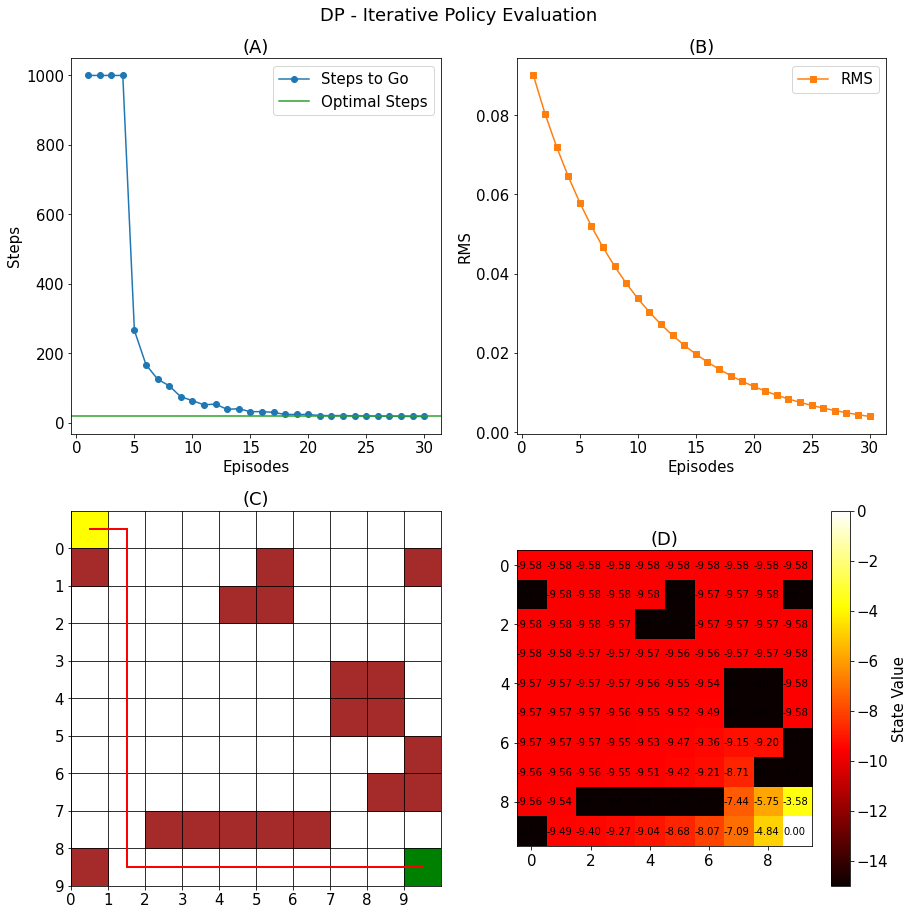

In [1124]:
with open('dp_it_pol_eval_steps.pickle', 'rb') as f_obj:
    dp_it_pol_eval_steps = dill.load(f_obj)
with open('dp_it_pol_eval_rms.pickle', 'rb') as f_obj:
    dp_it_pol_eval_rms = dill.load(f_obj)
with open('dp_it_pol_eval_V.pickle', 'rb') as f_obj:
    dp_it_pol_eval_V = dill.load(f_obj)
with open('dp_it_pol_eval_pi.pickle', 'rb') as f_obj:
    dp_it_pol_eval_pi = dill.load(f_obj)

plot(
    dp_it_pol_eval_steps,
    dp_it_pol_eval_rms,
    dp_it_pol_eval_V,
    dp_it_pol_eval_pi,
    OPTIMAL_STEPS,
    'DP - Iterative Policy Evaluation',
)
print('First episode reach optimal steps', np.where(dp_it_pol_eval_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(dp_it_pol_eval_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(dp_it_pol_eval_rms)} episodes')

## Policy Iteration

* Action controlled by policy

In [1096]:
dp_pol_it_V, _, grid, dp_pol_it_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(dp_pol_it_V)
dp_pol_it_steps = []
dp_pol_it_rms = []
for _ in range(30):
    # Policy Evaluation
    for i in range(M):
        for j in range(N):
            if (i == M - 1 and j == N - 1) or grid[i][j]:
                continue  # skip terminal state and blocks
            di, dj = ACTIONS[dp_pol_it_pi[i, j]]
            dp_pol_it_V[i, j] = -1 + GAMMA * V_pre[i + di, j + dj]
    # Compute error metrics
    dp_pol_it_steps.append(steps_to_go(dp_pol_it_V, grid))
    dp_pol_it_rms.append(np.linalg.norm(dp_pol_it_V - V_pre) / (M * N))
    # Policy Improvement
    policy_stable = True
    for i in range(M):
        for j in range(N):
            nsvs = get_next_state_vals(i, j, V_pre, grid, fv=lambda v: -1 + GAMMA * v)
            best_acts = find_best_actions(nsvs)
            A = rng.choice(best_acts)
            if A != dp_pol_it_pi[i, j]:
                policy_stable = False
                dp_pol_it_pi[i, j] = A
    if policy_stable:
        break
    V_pre = np.copy(dp_pol_it_V)

dp_pol_it_steps = np.array(dp_pol_it_steps)
dp_pol_it_rms = np.array(dp_pol_it_rms)

# Pickle everything
with open('dp_pol_it_steps.pickle', 'wb') as f_obj:
    dill.dump(dp_pol_it_steps, f_obj)
with open('dp_pol_it_rms.pickle', 'wb') as f_obj:
    dill.dump(dp_pol_it_rms, f_obj)
with open('dp_pol_it_V.pickle', 'wb') as f_obj:
    dill.dump(dp_pol_it_V, f_obj)
with open('dp_pol_it_pi.pickle', 'wb') as f_obj:
    dill.dump(dp_pol_it_pi, f_obj)

First episode reach optimal steps 23
First episode converge 26


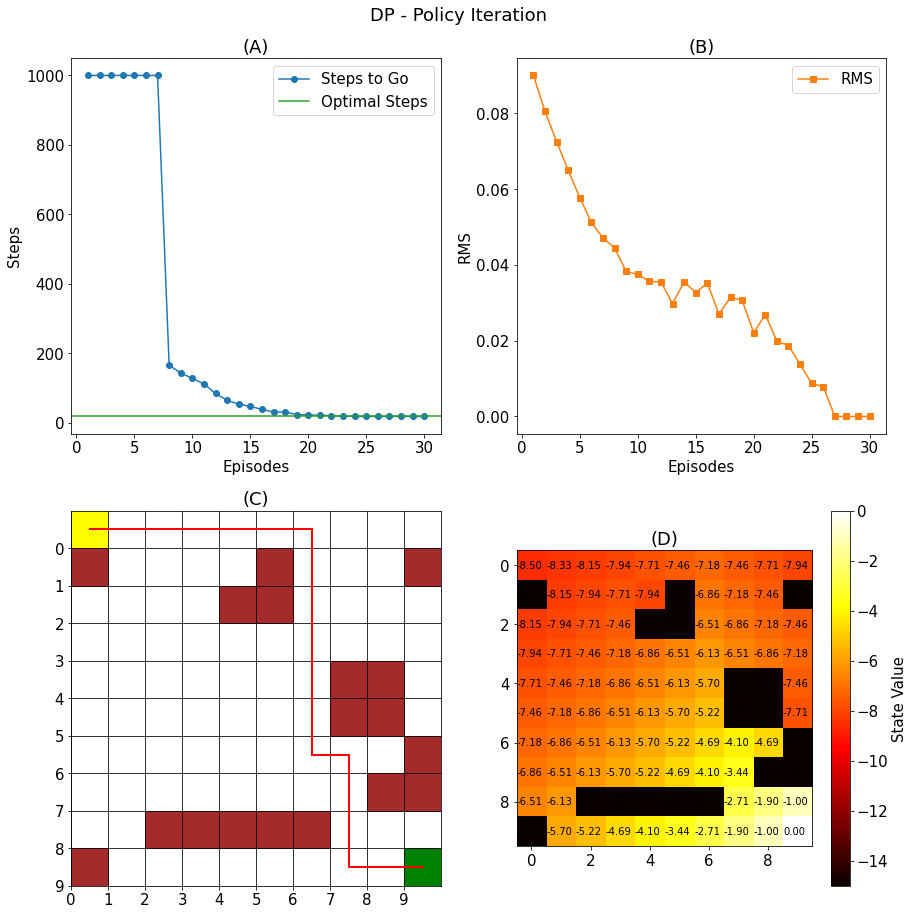

In [1125]:
with open('dp_pol_it_steps.pickle', 'rb') as f_obj:
    dp_pol_it_steps = dill.load(f_obj)
with open('dp_pol_it_rms.pickle', 'rb') as f_obj:
    dp_pol_it_rms = dill.load(f_obj)
with open('dp_pol_it_V.pickle', 'rb') as f_obj:
    dp_pol_it_V = dill.load(f_obj)
with open('dp_pol_it_pi.pickle', 'rb') as f_obj:
    dp_pol_it_pi = dill.load(f_obj)

plot(
    dp_pol_it_steps,
    dp_pol_it_rms,
    dp_pol_it_V,
    dp_pol_it_pi,
    OPTIMAL_STEPS,
    'DP - Policy Iteration',
)
print('First episode reach optimal steps', np.where(dp_pol_it_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(dp_pol_it_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(dp_pol_it_rms)} episodes')

## Value Iteration

* Action controlled by policy

In [1098]:
dp_val_it_V, _, grid, dp_val_it_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(dp_val_it_V)
dp_val_it_steps = []
dp_val_it_rms = []
for _ in range(30):
    for i in range(M):
        for j in range(N):
            if (i == M - 1 and j == N - 1) or grid[i][j]:
                continue  # skip terminal state and blocks
            nsvs = get_next_state_vals(i, j, V_pre, grid, fv=lambda v: -1 + GAMMA * v)
            dp_val_it_V[i, j] = max(nsvs)  # assign best next state value
    # Compute error metrics
    dp_val_it_steps.append(steps_to_go(dp_val_it_V, grid))
    dp_val_it_rms.append(np.linalg.norm(dp_val_it_V - V_pre) / (M * N))
    # update V_pre
    V_pre = np.copy(dp_val_it_V)

update_policy(dp_val_it_V, dp_val_it_pi, grid)
dp_val_it_steps = np.array(dp_val_it_steps)
dp_val_it_rms = np.array(dp_val_it_rms)

# Pickle everything
with open('dp_val_it_steps.pickle', 'wb') as f_obj:
    dill.dump(dp_val_it_steps, f_obj)
with open('dp_val_it_rms.pickle', 'wb') as f_obj:
    dill.dump(dp_val_it_rms, f_obj)
with open('dp_val_it_V.pickle', 'wb') as f_obj:
    dill.dump(dp_val_it_V, f_obj)
with open('dp_val_it_pi.pickle', 'wb') as f_obj:
    dill.dump(dp_val_it_pi, f_obj)

First episode reach optimal steps 16
First episode converge 18


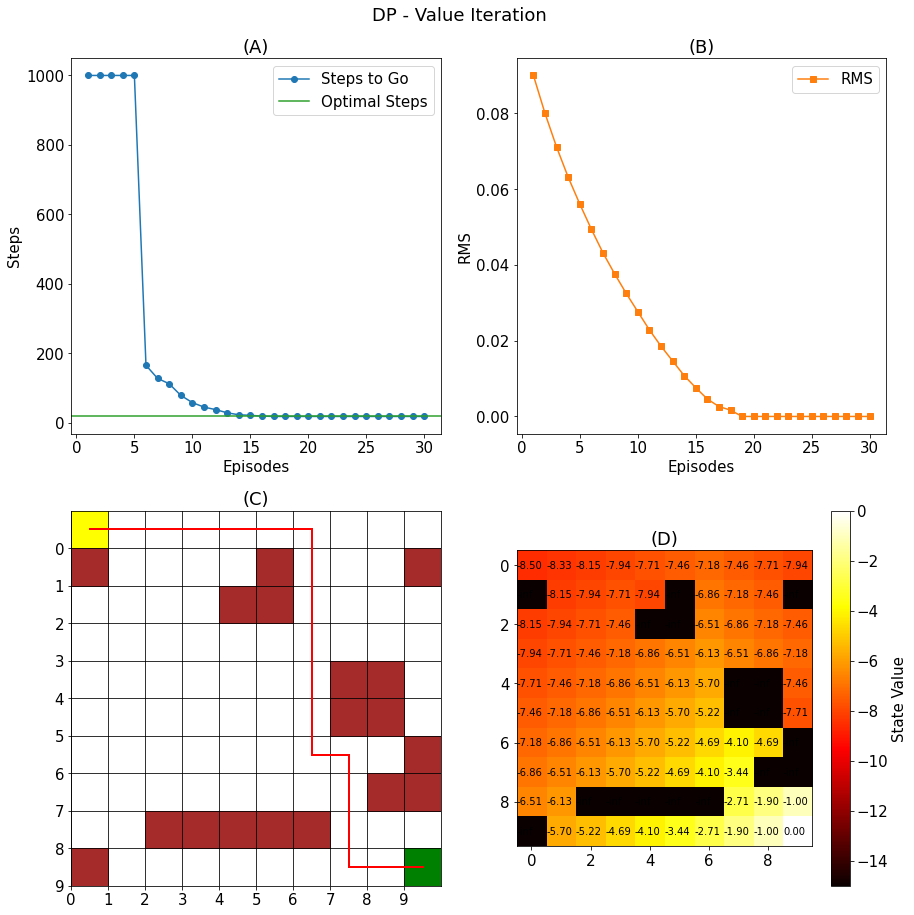

In [1126]:
with open('dp_val_it_steps.pickle', 'rb') as f_obj:
    dp_val_it_steps = dill.load(f_obj)
with open('dp_val_it_rms.pickle', 'rb') as f_obj:
    dp_val_it_rms = dill.load(f_obj)
with open('dp_val_it_V.pickle', 'rb') as f_obj:
    dp_val_it_V = dill.load(f_obj)
with open('dp_val_it_pi.pickle', 'rb') as f_obj:
    dp_val_it_pi = dill.load(f_obj)

plot(
    dp_val_it_steps,
    dp_val_it_rms,
    dp_val_it_V,
    dp_val_it_pi,
    OPTIMAL_STEPS,
    'DP - Value Iteration',
)
print('First episode reach optimal steps', np.where(dp_val_it_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(dp_val_it_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(dp_val_it_rms)} episodes')

# Monte Carlo

## First-visit Policy Evalutation

* Action completely random
* No need to set 1,000-step restriction per episode.

In [1120]:
mc_fst_vst_pol_eval_V, _, grid, mc_fst_vst_pol_eval_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(mc_fst_vst_pol_eval_V)
mc_fst_vst_pol_eval_steps = []
mc_fst_vst_pol_eval_rms = []
# store all the returns encountered at each state
returns = [[[] for _ in range(n)] for _ in range(m)]
for _ in range(100):
    states = []
    i, j = 0, 0
    while i != m - 1 or j != n - 1:  # One episode
        states.append((i, j))
        while True:
            di, dj = rng.choice(ACTIONS)  # take a random action
            ni, nj = i + di, j + dj
            if 0 <= ni < m and 0 <= nj < n and grid[ni, nj] == 0:
                i, j = ni, nj
                break
    seen = set()
    for k, state in enumerate(states):
        if state not in seen:  # only count first visit
            seen.add(state)
            G = -(GAMMA - GAMMA**(len(states) - k)) / (1 - GAMMA)
            returns[state[0]][state[1]].append(G)
            mc_fst_vst_pol_eval_V[state[0], state[1]] = np.mean(returns[state[0]][state[1]])
    # Compute error metrics
    mc_fst_vst_pol_eval_steps.append(steps_to_go(mc_fst_vst_pol_eval_V, grid))
    mc_fst_vst_pol_eval_rms.append(np.linalg.norm(mc_fst_vst_pol_eval_V - V_pre) / (M * N))
    # update V_pre
    V_pre = np.copy(mc_fst_vst_pol_eval_V)

update_policy(mc_fst_vst_pol_eval_V, mc_fst_vst_pol_eval_pi, grid)
mc_fst_vst_pol_eval_steps = np.array(mc_fst_vst_pol_eval_steps)
mc_fst_vst_pol_eval_rms = np.array(mc_fst_vst_pol_eval_rms)

# Pickle everything
with open('mc_fst_vst_pol_eval_steps.pickle', 'wb') as f_obj:
    dill.dump(mc_fst_vst_pol_eval_steps, f_obj)
with open('mc_fst_vst_pol_eval_rms.pickle', 'wb') as f_obj:
    dill.dump(mc_fst_vst_pol_eval_rms, f_obj)
with open('mc_fst_vst_pol_eval_V.pickle', 'wb') as f_obj:
    dill.dump(mc_fst_vst_pol_eval_V, f_obj)
with open('mc_fst_vst_pol_eval_pi.pickle', 'wb') as f_obj:
    dill.dump(mc_fst_vst_pol_eval_pi, f_obj)

First episode reach optimal steps 37
RMS not converged yet after 100 episodes


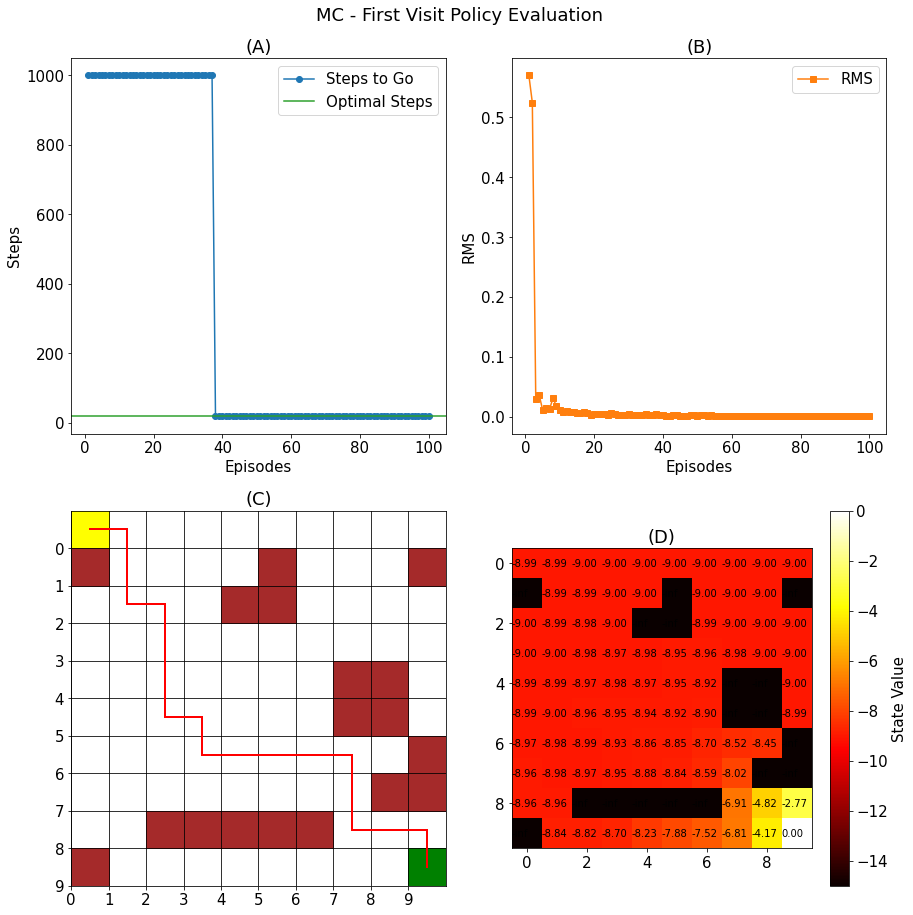

In [1127]:
with open('mc_fst_vst_pol_eval_steps.pickle', 'rb') as f_obj:
    mc_fst_vst_pol_eval_steps = dill.load(f_obj)
with open('mc_fst_vst_pol_eval_rms.pickle', 'rb') as f_obj:
    mc_fst_vst_pol_eval_rms = dill.load(f_obj)
with open('mc_fst_vst_pol_eval_V.pickle', 'rb') as f_obj:
    mc_fst_vst_pol_eval_V = dill.load(f_obj)
with open('mc_fst_vst_pol_eval_pi.pickle', 'rb') as f_obj:
    mc_fst_vst_pol_eval_pi = dill.load(f_obj)

plot(
    mc_fst_vst_pol_eval_steps,
    mc_fst_vst_pol_eval_rms,
    mc_fst_vst_pol_eval_V,
    mc_fst_vst_pol_eval_pi,
    OPTIMAL_STEPS,
    'MC - First Visit Policy Evaluation',
)
print('First episode reach optimal steps', np.where(mc_fst_vst_pol_eval_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(mc_fst_vst_pol_eval_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(mc_fst_vst_pol_eval_rms)} episodes')

## Exploring Starts

* Action follows policy
* Set 1,000-step restriction per episode in case an episode fails to terminate
* Failed episode discarded, i.e. not used to update state or action values.
* Initial action value set to a big negative value.

In [1102]:
mc_epl_starts_V, mc_epl_starts_Q, grid, mc_epl_starts_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(mc_epl_starts_V)
mc_epl_starts_steps = []
mc_epl_starts_rms = []
m, n = mc_epl_starts_V.shape
# store all the returns encountered at each state, action pair
returns = [[[[], [], [], []] for _ in range(n)] for _ in range(m)]
# Re-initialize Q values
for i in range(m):
    for j in range(n):
        if i == m - 1 and j == n - 1:
            continue
        mc_epl_starts_Q[i, j] = np.full(len(ACTIONS), -1000.0)

for _ in range(600):
    states = []
    while True:  # random start with state and action
        i, j, A = rng.integers(0, m), rng.integers(0, n), rng.integers(0, len(ACTIONS))
        di, dj = ACTIONS[A]
        ni, nj = i + di, j + dj
        if 0 <= ni < m and 0 <= nj < n and grid[ni, nj] == 0 and grid[i, j] == 0:
            break
    c = 0
    max_steps = 1000
    while (i != m - 1 or j != n - 1) and c < max_steps:  # One episode
        states.append((i, j, A))
        i, j = i + ACTIONS[A][0], j + ACTIONS[A][1]
        if any(returns[i][j]):  # the next state has been visited before
            A = mc_epl_starts_pi[i, j]
        else:  # the next state hasn't been visited, use random action
            while True:
                A = rng.integers(0, len(ACTIONS))
                ni, nj = i + ACTIONS[A][0], j + ACTIONS[A][1]
                if 0 <= ni < m and 0 <= nj < n and grid[ni, nj] == 0:
                    break
        c += 1
    if c < max_steps:  # Only update state values when an episode reaches terminal state
        seen = set()
        for k, state in enumerate(states):
            if state not in seen:  # only count first visit
                seen.add(state)
                G = -(GAMMA - GAMMA**(len(states) - k)) / (1 - GAMMA)
                returns[state[0]][state[1]][state[2]].append(G)
                mc_epl_starts_Q[state[0], state[1], state[2]] = np.mean(returns[state[0]][state[1]][state[2]])
        # update V and pi
        mc_epl_starts_V = np.max(mc_epl_starts_Q, axis=2)
        mc_epl_starts_V[m - 1, n - 1] = 0
        update_policy(mc_epl_starts_V, mc_epl_starts_pi, grid)
        # Compute error metrics
        mc_epl_starts_steps.append(steps_to_go(mc_epl_starts_V, grid))
        mc_epl_starts_rms.append(np.linalg.norm(mc_epl_starts_V - V_pre) / (M * N))
        # update V_pre
        V_pre = np.copy(mc_epl_starts_V)

update_policy(mc_epl_starts_V, mc_epl_starts_pi, grid)
mc_epl_starts_steps = np.array(mc_epl_starts_steps)
mc_epl_starts_rms = np.array(mc_epl_starts_rms)

# Pickle everything
with open('mc_epl_starts_steps.pickle', 'wb') as f_obj:
    dill.dump(mc_epl_starts_steps, f_obj)
with open('mc_epl_starts_rms.pickle', 'wb') as f_obj:
    dill.dump(mc_epl_starts_rms, f_obj)
with open('mc_epl_starts_V.pickle', 'wb') as f_obj:
    dill.dump(mc_epl_starts_V, f_obj)
with open('mc_epl_starts_pi.pickle', 'wb') as f_obj:
    dill.dump(mc_epl_starts_pi, f_obj)

First episode reach optimal steps 411
First episode converge 6


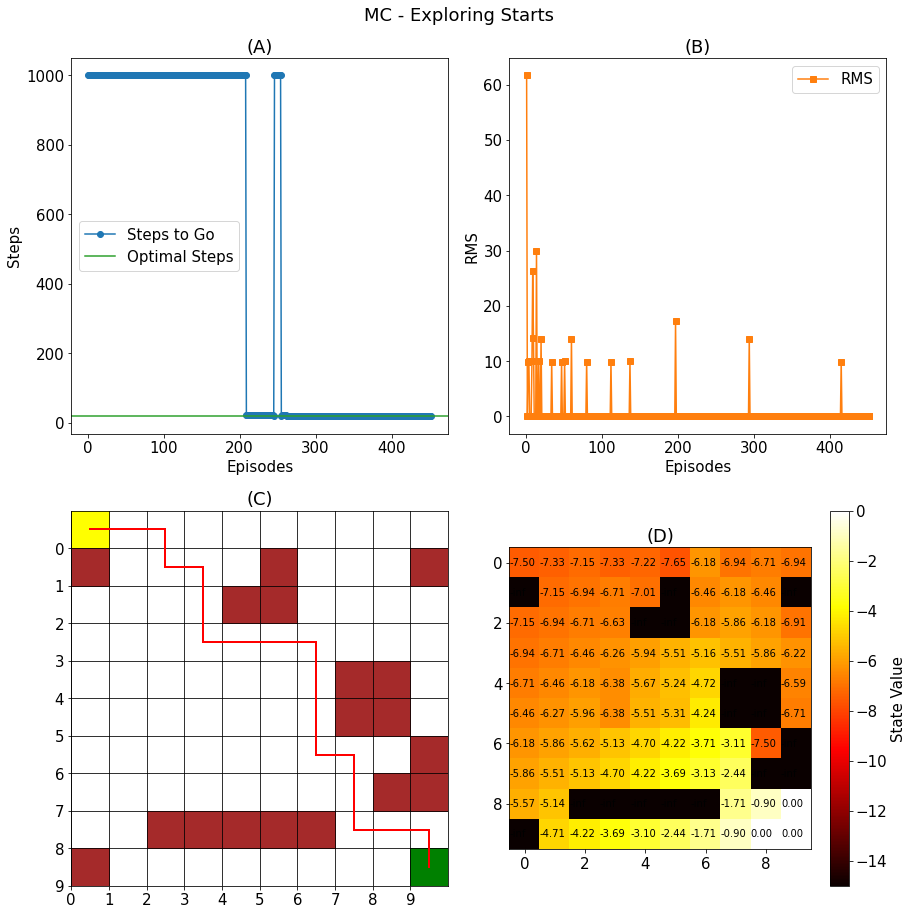

In [1128]:
with open('mc_epl_starts_steps.pickle', 'rb') as f_obj:
    mc_epl_starts_steps = dill.load(f_obj)
with open('mc_epl_starts_rms.pickle', 'rb') as f_obj:
    mc_epl_starts_rms = dill.load(f_obj)
with open('mc_epl_starts_V.pickle', 'rb') as f_obj:
    mc_epl_starts_V = dill.load(f_obj)
with open('mc_epl_starts_pi.pickle', 'rb') as f_obj:
    mc_epl_starts_pi = dill.load(f_obj)

plot(
    mc_epl_starts_steps,
    mc_epl_starts_rms,
    mc_epl_starts_V,
    mc_epl_starts_pi,
    OPTIMAL_STEPS,
    'MC - Exploring Starts',
)
print('First episode reach optimal steps', np.where(mc_epl_starts_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(mc_epl_starts_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(mc_epl_starts_rms)} episodes')

## On-Policy MC Control

* Action follows policy
* Set 1,000-step restriction per episode in case an episode fails to terminate
* Failed episode discarded, i.e. not used to update state or action values.

In [1104]:
mc_on_policy_V, mc_on_policy_Q, grid, mc_on_policy_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(mc_on_policy_V)
mc_on_policy_steps = []
mc_on_policy_rms = []
m, n = mc_on_policy_V.shape
# store all the returns encountered at each state, action pair
returns = [[[[], [], [], []] for _ in range(n)] for _ in range(m)]

# set up epsilon-greedy policy. Initial policy as equal probability
# for each action
epsilon_pi = np.array([[[1 / len(ACTIONS)] * len(ACTIONS) for _ in range(n)] for _ in range(m)])

for _ in range(100):
    states = []
    i, j = 0, 0
    c = 0
    max_steps = 1000
    while (i != m - 1 or j != n - 1) and c < max_steps:  # One episode
        while True:
            A = rng.choice(len(ACTIONS), p=epsilon_pi[i, j])
            di, dj = ACTIONS[A]
            ni, nj = i + di, j + dj
            if 0 <= ni < m and 0 <= nj < n and grid[ni, nj] == 0:
                break  # valid action
        states.append((i, j, A))
        i, j = ni, nj
        c += 1
    if c < max_steps:  # only update state-action values when an episode succeeds
        seen = set()
        for k, state in enumerate(states):
            if state not in seen:  # only count first visit
                seen.add(state)
                G = -(GAMMA - GAMMA**(len(states) - k)) / (1 - GAMMA)
                returns[state[0]][state[1]][state[2]].append(G)
                mc_on_policy_Q[state[0], state[1], state[2]] = np.mean(returns[state[0]][state[1]][state[2]])
        # update V and pi
        mc_on_policy_V = np.max(mc_on_policy_Q, axis=2)
        mc_on_policy_V[m - 1, n - 1] = 0
        update_policy(mc_on_policy_V, mc_on_policy_pi, grid)
        # update epsilon_pi
        for i, j, _ in states:
            A_star = mc_on_policy_pi[i, j]
            for k in range(len(ACTIONS)):
                if k == A_star:
                    epsilon_pi[i, j, k] = 1 - EPSILON + EPSILON / len(ACTIONS)
                else:
                    epsilon_pi[i, j, k] = EPSILON / len(ACTIONS)

        # Compute error metrics
        mc_on_policy_steps.append(steps_to_go(mc_on_policy_V, grid))
        mc_on_policy_rms.append(np.linalg.norm(mc_on_policy_V - V_pre) / (M * N))
        # update V_pre
        V_pre = np.copy(mc_on_policy_V)

update_policy(mc_on_policy_V, mc_on_policy_pi, grid)
mc_on_policy_steps = np.array(mc_on_policy_steps)
mc_on_policy_rms = np.array(mc_on_policy_rms)

# Pickle everything
with open('mc_on_policy_steps.pickle', 'wb') as f_obj:
    dill.dump(mc_on_policy_steps, f_obj)
with open('mc_on_policy_rms.pickle', 'wb') as f_obj:
    dill.dump(mc_on_policy_rms, f_obj)
with open('mc_on_policy_V.pickle', 'wb') as f_obj:
    dill.dump(mc_on_policy_V, f_obj)
with open('mc_on_policy_pi.pickle', 'wb') as f_obj:
    dill.dump(mc_on_policy_pi, f_obj)

First episode reach optimal steps 5
RMS not converged yet after 89 episodes


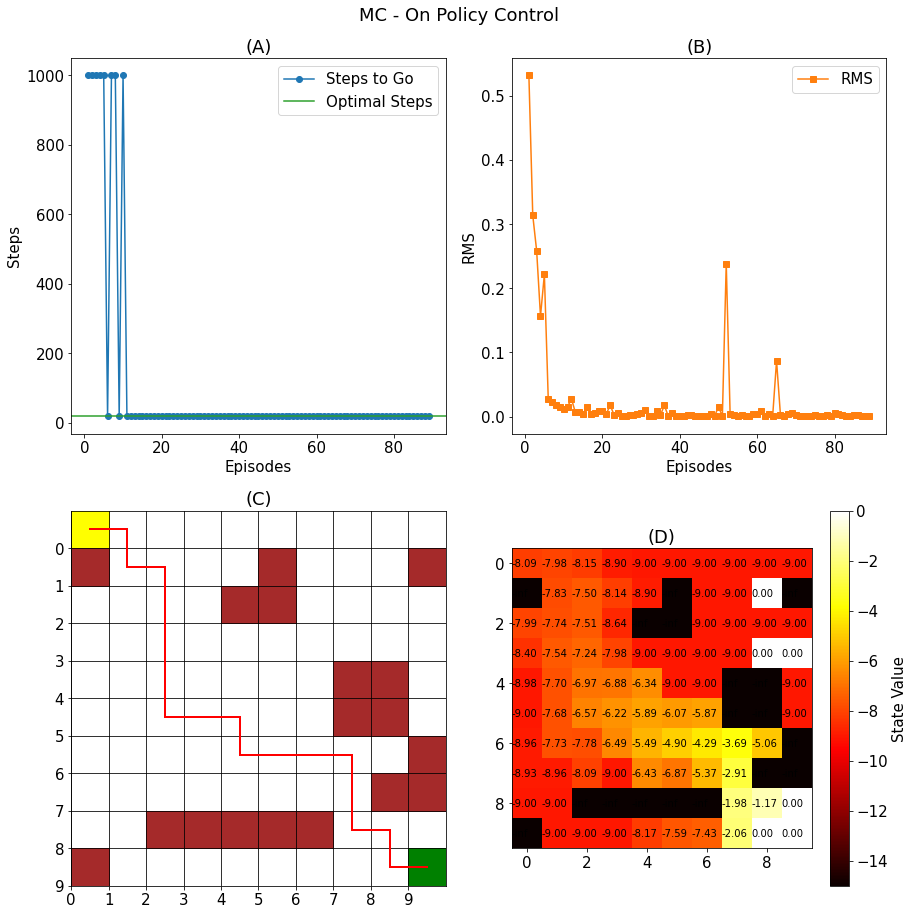

In [1129]:
with open('mc_on_policy_steps.pickle', 'rb') as f_obj:
    mc_on_policy_steps = dill.load(f_obj)
with open('mc_on_policy_rms.pickle', 'rb') as f_obj:
    mc_on_policy_rms = dill.load(f_obj)
with open('mc_on_policy_V.pickle', 'rb') as f_obj:
    mc_on_policy_V = dill.load(f_obj)
with open('mc_on_policy_pi.pickle', 'rb') as f_obj:
    mc_on_policy_pi = dill.load(f_obj)

plot(
    mc_on_policy_steps,
    mc_on_policy_rms,
    mc_on_policy_V,
    mc_on_policy_pi,
    OPTIMAL_STEPS,
    'MC - On Policy Control',
)
print('First episode reach optimal steps', np.where(mc_on_policy_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(mc_on_policy_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(mc_on_policy_steps)} episodes')

# Temporal Difference Learning

## TD(0)

* Action completely random
* No step restriction on episode

In [1139]:
td_zero_V, _, grid, td_zero_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(td_zero_V)
td_zero_steps = []
td_zero_rms = []
m, n = td_zero_V.shape

for _ in range(100):
    i, j = 0, 0
    while i != m - 1 or j != n - 1:  # One episode
        while True:  # take random action
            di, dj = rng.choice(ACTIONS)
            ni, nj = i + di, j + dj
            if 0 <= ni < m and 0 <= nj < n and grid[ni, nj] == 0:
                break  # valid action
        td_zero_V[i, j] = td_zero_V[i, j] + ALPHA * (-1 + GAMMA * td_zero_V[ni, nj] - td_zero_V[i, j])
        i, j = ni, nj
    
    # Compute error metrics
    td_zero_steps.append(steps_to_go(td_zero_V, grid))
    td_zero_rms.append(np.linalg.norm(td_zero_V - V_pre) / (M * N))
    # update V_pre
    V_pre = np.copy(td_zero_V)

update_policy(td_zero_V, td_zero_pi, grid)
td_zero_steps = np.array(td_zero_steps)
td_zero_rms = np.array(td_zero_rms)

# Pickle everything
with open('td_zero_steps.pickle', 'wb') as f_obj:
    dill.dump(td_zero_steps, f_obj)
with open('td_zero_rms.pickle', 'wb') as f_obj:
    dill.dump(td_zero_rms, f_obj)
with open('td_zero_V.pickle', 'wb') as f_obj:
    dill.dump(td_zero_V, f_obj)
with open('td_zero_pi.pickle', 'wb') as f_obj:
    dill.dump(td_zero_pi, f_obj)

First episode reach optimal steps 46
RMS not converged yet after 100 episodes


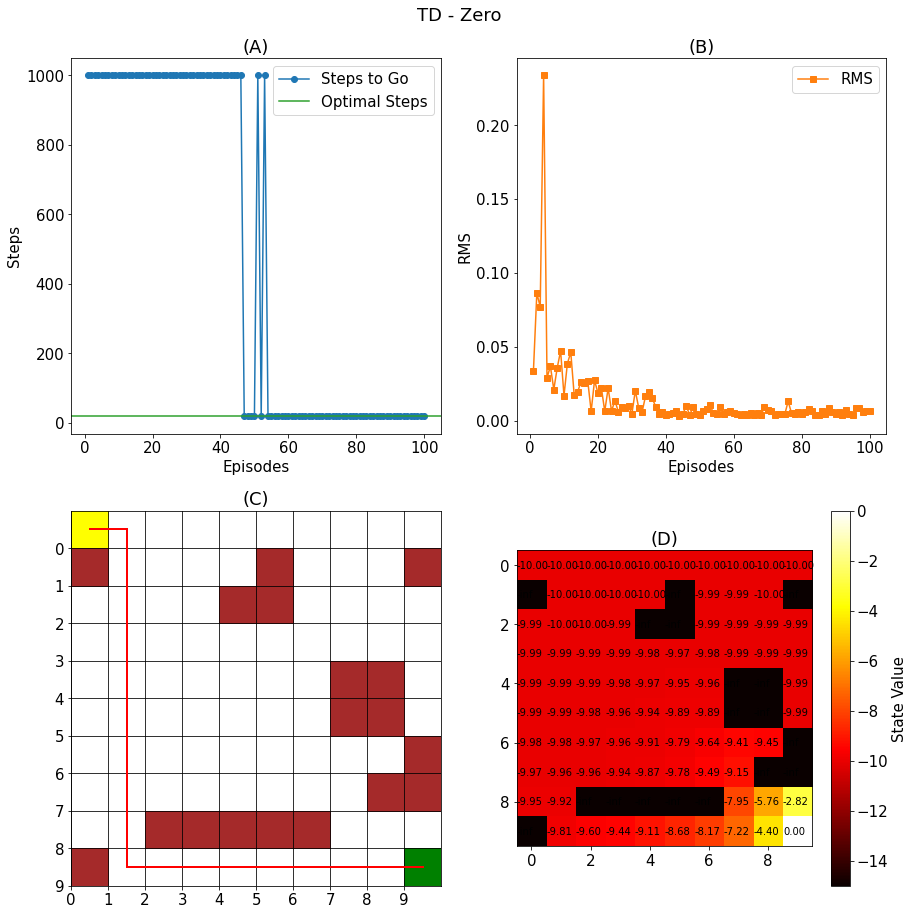

In [1140]:
with open('td_zero_steps.pickle', 'rb') as f_obj:
    td_zero_steps = dill.load(f_obj)
with open('td_zero_rms.pickle', 'rb') as f_obj:
    td_zero_rms = dill.load(f_obj)
with open('td_zero_V.pickle', 'rb') as f_obj:
    td_zero_V = dill.load(f_obj)
with open('td_zero_pi.pickle', 'rb') as f_obj:
    td_zero_pi = dill.load(f_obj)

plot(
    td_zero_steps,
    td_zero_rms,
    td_zero_V,
    td_zero_pi,
    OPTIMAL_STEPS,
    'TD - Zero',
)
print('First episode reach optimal steps', np.where(td_zero_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(td_zero_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(td_zero_steps)} episodes')

## Sarsa with TD Control

* Action follow policy using $\epsilon$-greedy
* No step restriction on episode

In [1141]:
sarsa_td_V, sarsa_td_Q, grid, sarsa_td_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(sarsa_td_V)
sarsa_td_steps = []
sarsa_td_rms = []
m, n = sarsa_td_V.shape

for _ in range(200):
    i, j = 0, 0
    A = get_epsilon_greedy_action(sarsa_td_Q, i, j, grid)
    while i != m - 1 or j != n - 1:  # One episode
        ni, nj = i + ACTIONS[A][0], j + ACTIONS[A][1]
        A_prime = get_epsilon_greedy_action(sarsa_td_Q, ni, nj, grid)
        sarsa_td_Q[i, j, A] = sarsa_td_Q[i, j, A] + ALPHA * (-1 + GAMMA * sarsa_td_Q[ni, nj, A_prime] - sarsa_td_Q[i, j, A])
        i, j = ni, nj
        A = A_prime

    # update V
    sarsa_td_V = np.max(sarsa_td_Q, axis=2)
    
    # Compute error metrics
    sarsa_td_steps.append(steps_to_go(sarsa_td_V, grid))
    sarsa_td_rms.append(np.linalg.norm(sarsa_td_V - V_pre) / (M * N))
    # update V_pre
    V_pre = np.copy(sarsa_td_V)

update_policy(sarsa_td_V, sarsa_td_pi, grid)
sarsa_td_steps = np.array(sarsa_td_steps)
sarsa_td_rms = np.array(sarsa_td_rms)

# Pickle everything
with open('sarsa_td_steps.pickle', 'wb') as f_obj:
    dill.dump(sarsa_td_steps, f_obj)
with open('sarsa_td_rms.pickle', 'wb') as f_obj:
    dill.dump(sarsa_td_rms, f_obj)
with open('sarsa_td_V.pickle', 'wb') as f_obj:
    dill.dump(sarsa_td_V, f_obj)
with open('sarsa_td_pi.pickle', 'wb') as f_obj:
    dill.dump(sarsa_td_pi, f_obj)

First episode reach optimal steps 5
RMS not converged yet after 200 episodes


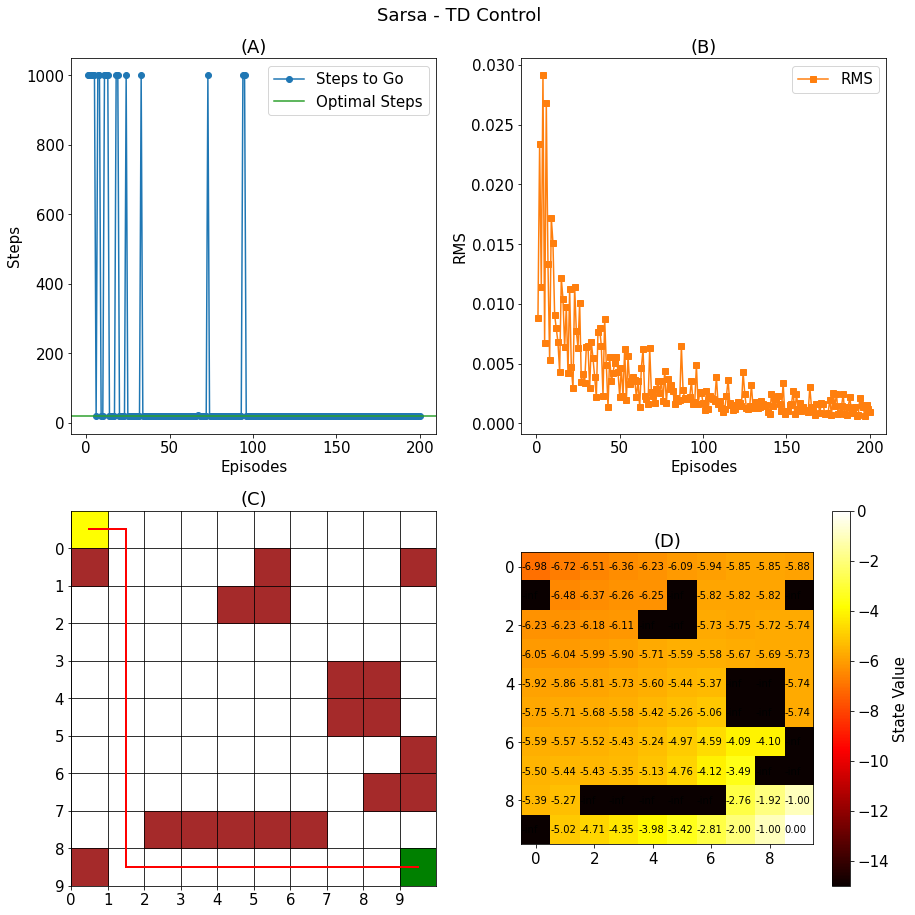

In [1142]:
with open('sarsa_td_steps.pickle', 'rb') as f_obj:
    sarsa_td_steps = dill.load(f_obj)
with open('sarsa_td_rms.pickle', 'rb') as f_obj:
    sarsa_td_rms = dill.load(f_obj)
with open('sarsa_td_V.pickle', 'rb') as f_obj:
    sarsa_td_V = dill.load(f_obj)
with open('sarsa_td_pi.pickle', 'rb') as f_obj:
    sarsa_td_pi = dill.load(f_obj)

plot(
    sarsa_td_steps,
    sarsa_td_rms,
    sarsa_td_V,
    sarsa_td_pi,
    OPTIMAL_STEPS,
    'Sarsa - TD Control',
)
print('First episode reach optimal steps', np.where(sarsa_td_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(sarsa_td_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(sarsa_td_steps)} episodes')

## Q-learning with TD Control

* Action follow policy using $\epsilon$-greedy
* No step restriction on episode

In [1143]:
q_learn_td_V, q_learn_td_Q, grid, q_learn_td_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(q_learn_td_V)
q_learn_td_steps = []
q_learn_td_rms = []
m, n = q_learn_td_V.shape

for _ in range(100):
    i, j = 0, 0
    while i != m - 1 or j != n - 1:  # One episode
        A = get_epsilon_greedy_action(q_learn_td_Q, i, j, grid)
        ni, nj = i + ACTIONS[A][0], j + ACTIONS[A][1]
        q_learn_td_Q[i, j, A] = q_learn_td_Q[i, j, A] + ALPHA * (-1 + GAMMA * max(q_learn_td_Q[ni, nj]) - q_learn_td_Q[i, j, A])
        i, j = ni, nj

    # update V
    q_learn_td_V = np.max(q_learn_td_Q, axis=2)
    
    # Compute error metrics
    q_learn_td_steps.append(steps_to_go(q_learn_td_V, grid))
    q_learn_td_rms.append(np.linalg.norm(q_learn_td_V - V_pre) / (M * N))
    # update V_pre
    V_pre = np.copy(q_learn_td_V)

update_policy(q_learn_td_V, q_learn_td_pi, grid)
q_learn_td_steps = np.array(q_learn_td_steps)
q_learn_td_rms = np.array(q_learn_td_rms)

# Pickle everything
with open('q_learn_td_steps.pickle', 'wb') as f_obj:
    dill.dump(q_learn_td_steps, f_obj)
with open('q_learn_td_rms.pickle', 'wb') as f_obj:
    dill.dump(q_learn_td_rms, f_obj)
with open('q_learn_td_V.pickle', 'wb') as f_obj:
    dill.dump(q_learn_td_V, f_obj)
with open('q_learn_td_pi.pickle', 'wb') as f_obj:
    dill.dump(q_learn_td_pi, f_obj)

First episode reach optimal steps 7
RMS not converged yet after 100 episodes


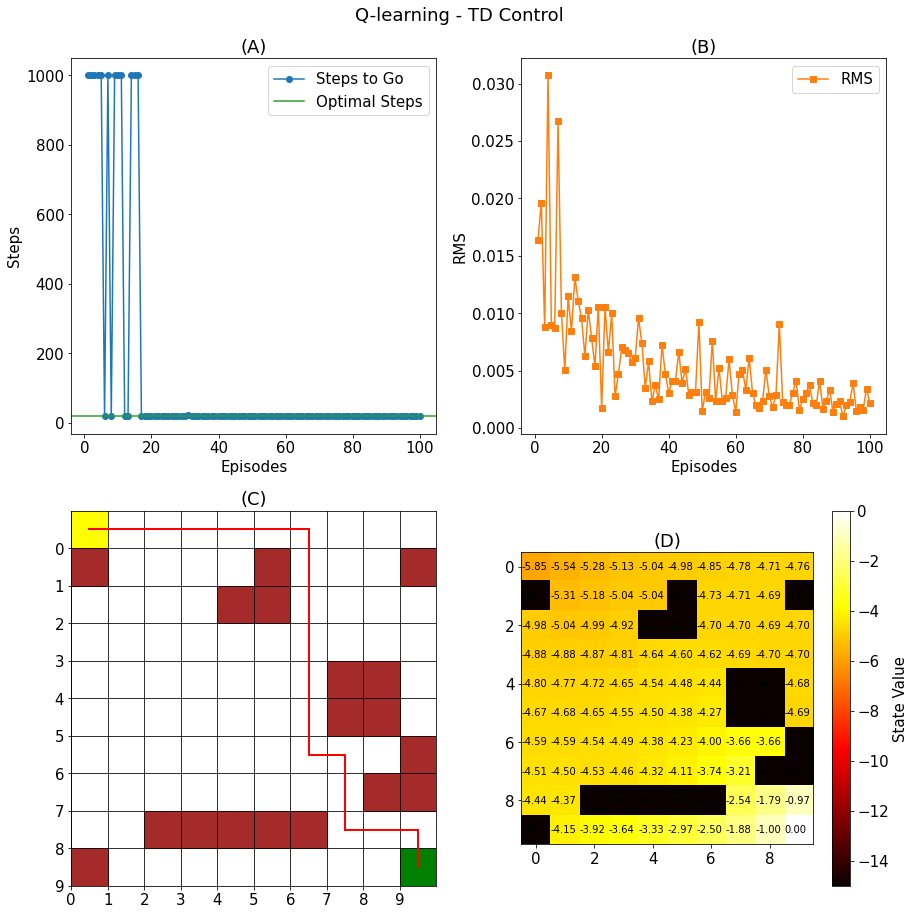

In [1144]:
with open('q_learn_td_steps.pickle', 'rb') as f_obj:
    q_learn_td_steps = dill.load(f_obj)
with open('q_learn_td_rms.pickle', 'rb') as f_obj:
    q_learn_td_rms = dill.load(f_obj)
with open('q_learn_td_V.pickle', 'rb') as f_obj:
    q_learn_td_V = dill.load(f_obj)
with open('q_learn_td_pi.pickle', 'rb') as f_obj:
    q_learn_td_pi = dill.load(f_obj)

plot(
    q_learn_td_steps,
    q_learn_td_rms,
    q_learn_td_V,
    q_learn_td_pi,
    OPTIMAL_STEPS,
    'Q-learning - TD Control',
)
print('First episode reach optimal steps', np.where(q_learn_td_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(q_learn_td_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(q_learn_td_steps)} episodes')

# Eligibility Tracing

## TD($\lambda$)

* Action completely random
* No step restriction on episode
* Use accumulating traces

In [1145]:
td_lambda_V, _, grid, td_lambda_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(td_lambda_V)
td_lambda_steps = []
td_lambda_rms = []
m, n = td_lambda_V.shape

for _ in range(100):
    # Initialize eligibility tracing
    E = np.array([[0.0] * n for _ in range(m)])
    i, j = 0, 0
    while i != m - 1 or j != n - 1:  # One episode
        while True:  # take random action
            di, dj = rng.choice(ACTIONS)
            ni, nj = i + di, j + dj
            if 0 <= ni < m and 0 <= nj < n and grid[ni, nj] == 0:
                break  # valid action
        delta = -1 + GAMMA * td_lambda_V[ni, nj] - td_lambda_V[i, j]
        E[i, j] += 1
        for p in range(m):
            for q in range(n):
                # value update based on eligibility tracing
                td_lambda_V[p, q] += ALPHA * delta * E[p, q]
                # Attenuation of eligibility tracing
                E[p, q] *= LAMBDA * GAMMA
        i, j = ni, nj
    
    # Compute error metrics
    td_lambda_steps.append(steps_to_go(td_lambda_V, grid))
    td_lambda_rms.append(np.linalg.norm(td_lambda_V - V_pre) / (M * N))
    # update V_pre
    V_pre = np.copy(td_lambda_V)

update_policy(td_lambda_V, td_lambda_pi, grid)
td_lambda_steps = np.array(td_lambda_steps)
td_lambda_rms = np.array(td_lambda_rms)

# Pickle everything
with open('td_lambda_steps.pickle', 'wb') as f_obj:
    dill.dump(td_lambda_steps, f_obj)
with open('td_lambda_rms.pickle', 'wb') as f_obj:
    dill.dump(td_lambda_rms, f_obj)
with open('td_lambda_V.pickle', 'wb') as f_obj:
    dill.dump(td_lambda_V, f_obj)
with open('td_lambda_pi.pickle', 'wb') as f_obj:
    dill.dump(td_lambda_pi, f_obj)

First episode reach optimal steps 25
RMS not converged yet after 100 episodes


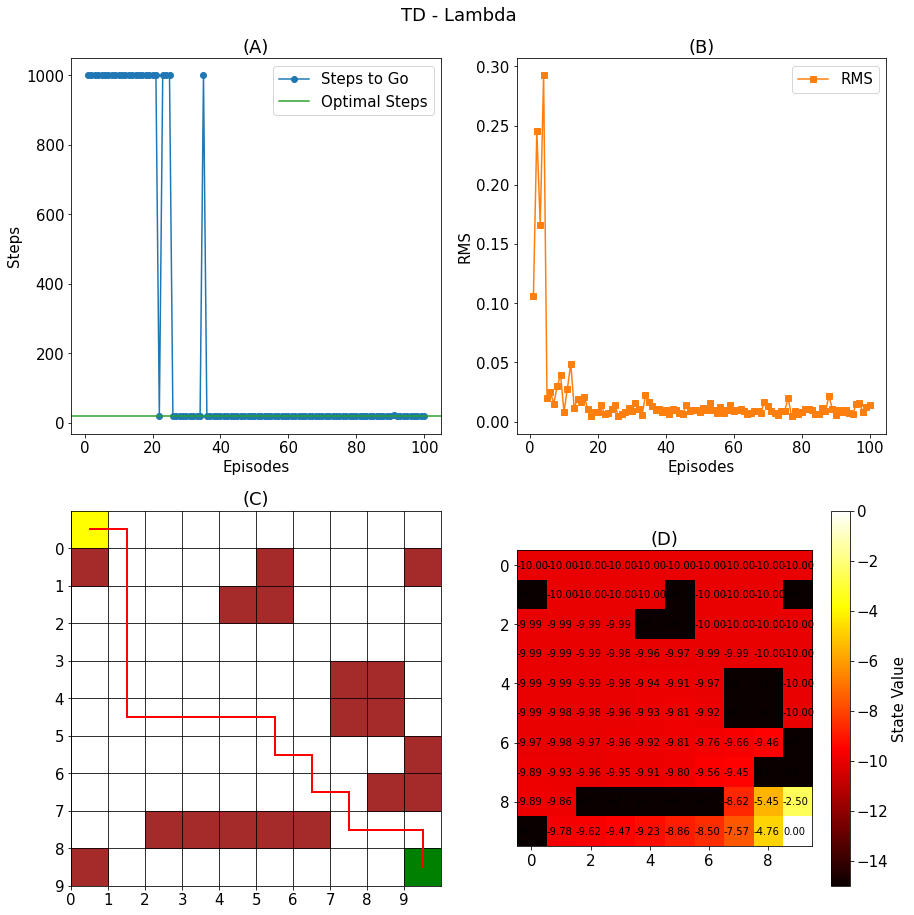

In [1151]:
with open('td_lambda_steps.pickle', 'rb') as f_obj:
    td_lambda_steps = dill.load(f_obj)
with open('td_lambda_rms.pickle', 'rb') as f_obj:
    td_lambda_rms = dill.load(f_obj)
with open('td_lambda_V.pickle', 'rb') as f_obj:
    td_lambda_V = dill.load(f_obj)
with open('td_lambda_pi.pickle', 'rb') as f_obj:
    td_lambda_pi = dill.load(f_obj)

plot(
    td_lambda_steps,
    td_lambda_rms,
    td_lambda_V,
    td_lambda_pi,
    OPTIMAL_STEPS,
    'TD - Lambda',
)
print('First episode reach optimal steps', np.where(td_lambda_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(td_lambda_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(td_lambda_steps)} episodes')

## Sarsa($\lambda$)

* Action follow policy using $\epsilon$-greedy
* No step restriction on episode
* Use accumulating traces

In [1147]:
sarsa_lambda_V, sarsa_lambda_Q, grid, sarsa_lambda_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(sarsa_lambda_V)
sarsa_lambda_steps = []
sarsa_lambda_rms = []
m, n = sarsa_lambda_V.shape

for _ in range(100):
    # Initialize eligibility tracing
    E = np.array([[[0.0] * len(ACTIONS) for _ in range(n)] for _ in range(m)])
    i, j = 0, 0
    A = get_epsilon_greedy_action(sarsa_lambda_Q, i, j, grid)
    while i != m - 1 or j != n - 1:  # One episode
        ni, nj = i + ACTIONS[A][0], j + ACTIONS[A][1]
        A_prime = get_epsilon_greedy_action(sarsa_lambda_Q, ni, nj, grid)
        delta = -1 + GAMMA * sarsa_lambda_Q[ni, nj, A_prime] - sarsa_lambda_Q[i, j, A]
        E[i, j, A] += 1  # accumulating traces
        for p in range(m):
            for q in range(n):
                for k in range(len(ACTIONS)):
                    sarsa_lambda_Q[p, q, k] += ALPHA * delta * E[p, q, k]
                    E[p, q, k] *= LAMBDA * GAMMA  # attenuation
        i, j = ni, nj
        A = A_prime

    # update V
    sarsa_lambda_V = np.max(sarsa_lambda_Q, axis=2)
    
    # Compute error metrics
    sarsa_lambda_steps.append(steps_to_go(sarsa_lambda_V, grid))
    sarsa_lambda_rms.append(np.linalg.norm(sarsa_lambda_V - V_pre) / (M * N))
    # update V_pre
    V_pre = np.copy(sarsa_lambda_V)

update_policy(sarsa_lambda_V, sarsa_lambda_pi, grid)
sarsa_lambda_steps = np.array(sarsa_lambda_steps)
sarsa_lambda_rms = np.array(sarsa_lambda_rms)

# Pickle everything
with open('sarsa_lambda_steps.pickle', 'wb') as f_obj:
    dill.dump(sarsa_lambda_steps, f_obj)
with open('sarsa_lambda_rms.pickle', 'wb') as f_obj:
    dill.dump(sarsa_lambda_rms, f_obj)
with open('sarsa_lambda_V.pickle', 'wb') as f_obj:
    dill.dump(sarsa_lambda_V, f_obj)
with open('sarsa_lambda_pi.pickle', 'wb') as f_obj:
    dill.dump(sarsa_lambda_pi, f_obj)

First episode reach optimal steps 7
RMS not converged yet after 100 episodes


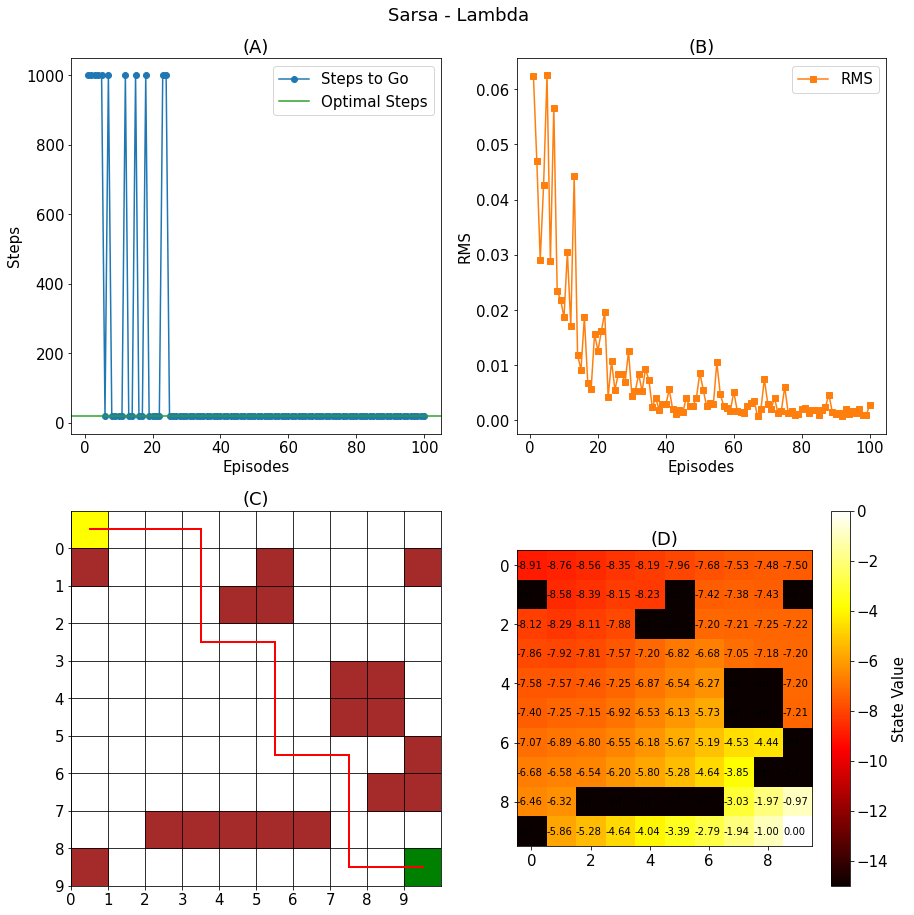

In [1148]:
with open('sarsa_lambda_steps.pickle', 'rb') as f_obj:
    sarsa_lambda_steps = dill.load(f_obj)
with open('sarsa_lambda_rms.pickle', 'rb') as f_obj:
    sarsa_lambda_rms = dill.load(f_obj)
with open('sarsa_lambda_V.pickle', 'rb') as f_obj:
    sarsa_lambda_V = dill.load(f_obj)
with open('sarsa_lambda_pi.pickle', 'rb') as f_obj:
    sarsa_lambda_pi = dill.load(f_obj)

plot(
    sarsa_lambda_steps,
    sarsa_lambda_rms,
    sarsa_lambda_V,
    sarsa_lambda_pi,
    OPTIMAL_STEPS,
    'Sarsa - Lambda',
)
print('First episode reach optimal steps', np.where(sarsa_lambda_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(sarsa_lambda_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(sarsa_lambda_steps)} episodes')

## Watkin's Q($\lambda$)

* Action follow policy using $\epsilon$-greedy
* No step restriction on episode
* Use accumulating traces

In [1149]:
watkins_q_lambda_V, watkins_q_lambda_Q, grid, watkins_q_lambda_pi = initialize_grid(M, N, NUM_BLK, random_state=10)
rng = np.random.default_rng(42)
V_pre = np.copy(watkins_q_lambda_V)
watkins_q_lambda_steps = []
watkins_q_lambda_rms = []
m, n = watkins_q_lambda_V.shape

for _ in range(100):
    # Initialize eligibility tracing
    E = np.array([[[0.0] * len(ACTIONS) for _ in range(n)] for _ in range(m)])
    i, j = 0, 0
    A = get_epsilon_greedy_action(watkins_q_lambda_Q, i, j, grid)
    while i != m - 1 or j != n - 1:  # One episode
        ni, nj = i + ACTIONS[A][0], j + ACTIONS[A][1]
        A_prime = get_epsilon_greedy_action(watkins_q_lambda_Q, ni, nj, grid)
        A_star = np.argmax(watkins_q_lambda_Q[ni, nj])
        if watkins_q_lambda_Q[ni, nj, A_prime] == watkins_q_lambda_Q[ni, nj, A_star]:
            A_star = A_prime
        delta = -1 + GAMMA * watkins_q_lambda_Q[ni, nj, A_star] - watkins_q_lambda_Q[i, j, A]
        E[i, j, A] += 1  # accumulating traces
        for p in range(m):
            for q in range(n):
                for k in range(len(ACTIONS)):
                    watkins_q_lambda_Q[p, q, k] += ALPHA * delta * E[p, q, k]
                    if k == A_star:
                        E[p, q, k] *= LAMBDA * GAMMA  # attenuation
                    else:  # action not greedy, thus its error shall not be highly restricted
                        E[p, q, k] = 0
        i, j = ni, nj
        A = A_prime

    # update V
    watkins_q_lambda_V = np.max(watkins_q_lambda_Q, axis=2)
    
    # Compute error metrics
    watkins_q_lambda_steps.append(steps_to_go(watkins_q_lambda_V, grid))
    watkins_q_lambda_rms.append(np.linalg.norm(watkins_q_lambda_V - V_pre) / (M * N))
    # update V_pre
    V_pre = np.copy(watkins_q_lambda_V)

update_policy(watkins_q_lambda_V, watkins_q_lambda_pi, grid)
watkins_q_lambda_steps = np.array(watkins_q_lambda_steps)
watkins_q_lambda_rms = np.array(watkins_q_lambda_rms)

# Pickle everything
with open('watkins_q_lambda_steps.pickle', 'wb') as f_obj:
    dill.dump(watkins_q_lambda_steps, f_obj)
with open('watkins_q_lambda_rms.pickle', 'wb') as f_obj:
    dill.dump(watkins_q_lambda_rms, f_obj)
with open('watkins_q_lambda_V.pickle', 'wb') as f_obj:
    dill.dump(watkins_q_lambda_V, f_obj)
with open('watkins_q_lambda_pi.pickle', 'wb') as f_obj:
    dill.dump(watkins_q_lambda_pi, f_obj)

First episode reach optimal steps 7
RMS not converged yet after 100 episodes


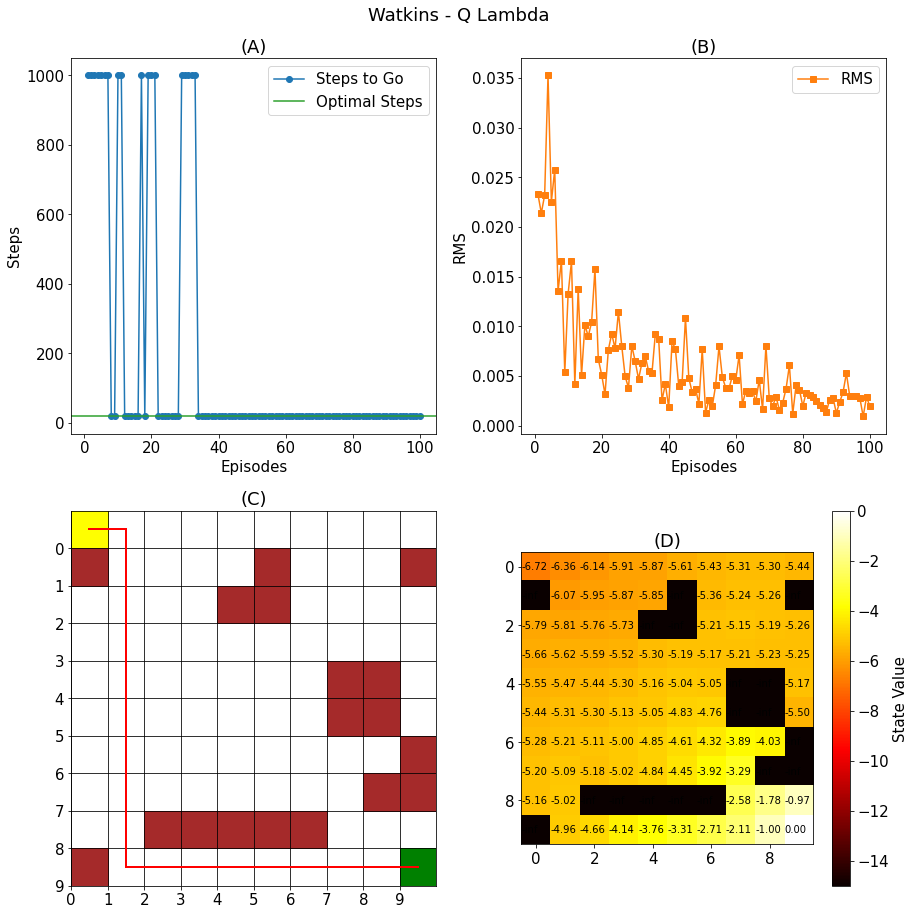

In [1150]:
with open('watkins_q_lambda_steps.pickle', 'rb') as f_obj:
    watkins_q_lambda_steps = dill.load(f_obj)
with open('watkins_q_lambda_rms.pickle', 'rb') as f_obj:
    watkins_q_lambda_rms = dill.load(f_obj)
with open('watkins_q_lambda_V.pickle', 'rb') as f_obj:
    watkins_q_lambda_V = dill.load(f_obj)
with open('watkins_q_lambda_pi.pickle', 'rb') as f_obj:
    watkins_q_lambda_pi = dill.load(f_obj)

plot(
    watkins_q_lambda_steps,
    watkins_q_lambda_rms,
    watkins_q_lambda_V,
    watkins_q_lambda_pi,
    OPTIMAL_STEPS,
    'Watkins - Q Lambda',
)
print('First episode reach optimal steps', np.where(watkins_q_lambda_steps == OPTIMAL_STEPS)[0][0])
try:
    print('First episode converge', np.where(np.isclose(watkins_q_lambda_rms, 0.0))[0][0])
except IndexError:
    print(f'RMS not converged yet after {len(watkins_q_lambda_steps)} episodes')

# Draw Grid World without Path

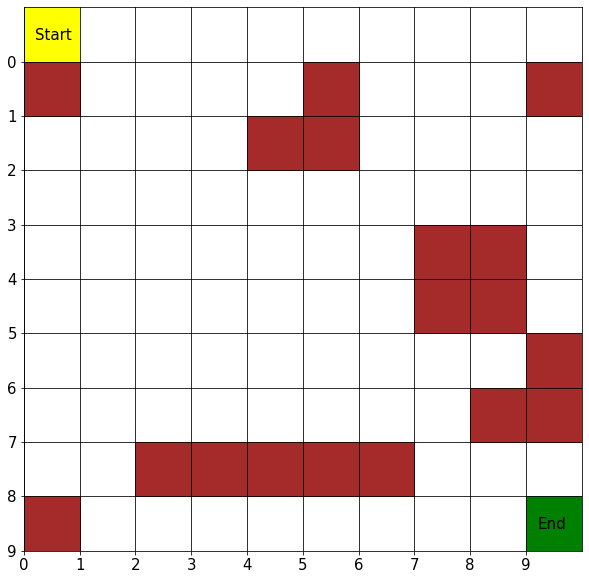

In [1119]:
_, _, grid, _ = initialize_grid(M, N, NUM_BLK, random_state=10)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.grid(True)
ax.set_xticks(np.arange(N))
ax.set_xlim(left=0, right=N)
ax.set_yticks(np.arange(M))
ax.set_ylim(top=M - 1, bottom=-1)
ax.invert_yaxis()  # invert y axis such that 0 is at the top

# label start, end and blocks
ax.add_patch(Rectangle((0, -1), 1, 1, fill=True, color='yellow'))
ax.annotate(xy=(0.2, -0.4), text='Start')
ax.add_patch(Rectangle((n - 1, m - 2), 1, 1, fill=True, color='green'))
ax.annotate(xy=(n - 1 + 0.2, m - 1.4), text='End')
for i, j in zip(*np.where(grid == 1)):
    ax.add_patch(Rectangle((j, i - 1), 1, 1, fill=True, color='brown'))

plt.savefig('grid_world.pdf')